### Unidad II. Regresiones y reducción de dimensionalidad.

## Análisis de Regresión Logística.

- Curvas ROC.

#### Lectura de datos

Puedo leer la tabla desde un archivo [*csv (comma-separated values)*](https://en.wikipedia.org/wiki/Comma-separated_values) (por ejemplo, exportado de Excel) usando [`readtable` de *DataFrames*](http://juliastats.github.io/DataFrames.jl/stable/)

In [1]:
using DataFrames
survey = readtable("survey.csv")
head(survey)

,Sex,WrHnd,NWHnd,WHnd,Fold,Pulse,Clap,Exer,Smoke,Height,MI,Age
1,Female,18.5,18.0,Right,R on L,92,Left,Some,Never,173.0,Metric,18.25
2,Male,19.5,20.5,Left,R on L,104,Left,None,Regul,177.8,Imperial,17.583
3,Male,18.0,13.3,Right,L on R,87,Neither,None,Occas,NaN,NA,16.917
4,Male,18.8,18.9,Right,R on L,NA,Neither,None,Never,160.0,Metric,20.333
5,Male,20.0,20.0,Right,Neither,35,Right,Some,Never,165.0,Metric,23.667
6,Female,18.0,17.7,Right,L on R,64,Right,Some,Never,172.72,Imperial,21.0


Para este análisis los `NaN` ([*not a number*](https://en.wikipedia.org/wiki/NaN)) pueden ser tomados como valores faltantes: `NA` (*not available*)

In [2]:
survey = readtable("survey.csv", nastrings=["","NA","NaN"])
head(survey)

,Sex,WrHnd,NWHnd,WHnd,Fold,Pulse,Clap,Exer,Smoke,Height,MI,Age
1,Female,18.5,18.0,Right,R on L,92,Left,Some,Never,173.0,Metric,18.25
2,Male,19.5,20.5,Left,R on L,104,Left,None,Regul,177.8,Imperial,17.583
3,Male,18.0,13.3,Right,L on R,87,Neither,None,Occas,NA,NA,16.917
4,Male,18.8,18.9,Right,R on L,NA,Neither,None,Never,160.0,Metric,20.333
5,Male,20.0,20.0,Right,Neither,35,Right,Some,Never,165.0,Metric,23.667
6,Female,18.0,17.7,Right,L on R,64,Right,Some,Never,172.72,Imperial,21.0


### [Regresión Logística](https://en.wikipedia.org/wiki/Logistic_regression)

Supongamos, que partiendo de los datos de la encuesta queremos generar un modelo que nos permita clasificar hombres y mujeres dependiendo de su altura.  
Podríamos darle un valor numérico a hombres y mujeres (`0`, `1`), para luego realizar una regresión lineal que permita predecir estos valores.  
Cómo no disponemos de la posibilidad de conseguir nuevos datos (por ejemplo, no podemos permitirnos una segunda encuesta), vamos a hacer esta primera exploración en una porción del *dataset*.  

In [3]:
subset = survey[:,[:Sex,:Height]] # Me quedo con las columnas de interés
head(subset)

,Sex,Height
1,Female,173.0
2,Male,177.8
3,Male,NA
4,Male,160.0
5,Male,165.0
6,Female,172.72


In [4]:
completecases!(subset) # Elimina las filas que tienen al menos un NA
head(subset)

,Sex,Height
1,Female,173.0
2,Male,177.8
3,Male,160.0
4,Male,165.0
5,Female,172.72
6,Male,182.88


Le doy un valor numérico a hombres y mujeres (`0`, `1`)

In [5]:
subset[:Sex] = [ sex == "Male" ? 0 : 1 for sex in subset[:Sex]]
head(subset)

,Sex,Height
1,1,173.0
2,0,177.8
3,0,160.0
4,0,165.0
5,1,172.72
6,0,182.88


In [6]:
N = nrow(subset)

208

In [7]:
div(N,30)

6

Para evitar [**hipótesis post hoc**](https://en.wikipedia.org/wiki/Testing_hypotheses_suggested_by_the_data), y para poder entrenar nuestro clasificador sin [**overfitting**](https://en.wikipedia.org/wiki/Overfitting), usaremos una estrategia de <a href=”https://en.wikipedia.org/wiki/Cross-validation_(statistics)”>**cross validation**</a>. En este caso será un 6-fold cross-validation (para poder tener cerca de 30 puntos en casa grupo de prueba) estratificado (para poder conservar la proporción de hombres y mujeres en cada grupo de datos) usando [MLBase](http://mlbasejl.readthedocs.io/en/latest/crossval.html).


In [8]:
using MLBase

In [9]:
cv = StratifiedKfold(subset[:Sex], 6)

MLBase.StratifiedKfold(208,Array{Int64,1}[[34,132,63,88,95,66,200,202,208,119  …  146,152,37,110,29,124,72,185,58,172],[126,147,3,162,105,61,45,21,30,103  …  79,17,47,48,140,127,69,167,125,199]],6,[17.0,17.6667])

In [10]:
índices_cv = collect(cv)

6-element Array{Any,1}:
 [1,2,4,5,6,7,8,9,10,11  …  196,197,198,199,201,203,204,205,206,207]  
 [1,2,3,6,8,9,10,11,13,14  …  199,200,201,202,203,204,205,206,207,208]
 [1,2,3,4,5,6,7,8,9,10  …  198,199,200,201,202,203,204,205,207,208]   
 [1,2,3,4,5,6,7,8,11,12  …  195,196,197,198,199,200,201,202,206,208]  
 [2,3,4,5,7,9,10,11,12,13  …  198,199,200,202,203,204,205,206,207,208]
 [1,3,4,5,6,7,8,9,10,11  …  198,200,201,202,203,204,205,206,207,208]  

In [11]:
índices_exploración = índices_cv[1]
exploración = subset[índices_exploración,:]

describe(exploración)

Sex
Min      0.0
1st Qu.  0.0
Median   0.0
Mean     0.4913294797687861
3rd Qu.  1.0
Max      1.0
NAs      0
NA%      0.0%

Height
Min      150.0
1st Qu.  165.0
Median   171.0
Mean     172.4492485549133
3rd Qu.  180.0
Max      200.0
NAs      0
NA%      0.0%



In [12]:
using Plots, StatPlots
pyplot(size=(400,200))

Plots.PyPlotBackend()

In [13]:
using GLM
using Distributions

In [14]:
lineal = glm(@formula(Sex ~ Height), exploración, Normal(), IdentityLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Normal{Float64},GLM.IdentityLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Sex ~ 1 + Height

Coefficients:
               Estimate  Std.Error z value Pr(>|z|)
(Intercept)     6.33119   0.496178 12.7599   <1e-36
Height       -0.0338642 0.00287252 -11.789   <1e-31



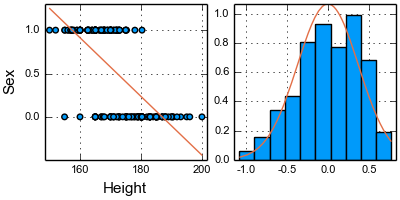

In [15]:
reg_plot = scatter(exploración, :Height, :Sex)
Plots.abline!(reg_plot, coef(lineal)[2], coef(lineal)[1])

residuos = exploración[:Sex] - predict(lineal)
normal = Normal(0,std(residuos))
res_plot = histogram(residuos, bins=10, normed=true)
plot!(res_plot, res -> pdf(normal, res), minimum(residuos), maximum(residuos))

plot(reg_plot, res_plot, legend=false)

En clase anteriores vimos que en caso de no disponer de un test estadístico en Julia, podíamos usar los tests implementados en R usando RCall. También es posible acceder desde Julia a los tests implementados en **Python** usando la biblioteca [**PyCall**](https://github.com/stevengj/PyCall.jl). En este caso por ejemplo, para testear la normalidad de los residuos usando la implementación de la [prueba de Shapiro en **SciPy**](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html), y si la media de los residuos es 0 usando la [prueba T de Student para una muestra](http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.stats.ttest_1samp.html).

In [16]:
using PyCall

In [17]:
@pyimport scipy.stats as stats

In [18]:
stats.shapiro(residuos) # W, P

(0.9790576100349426,0.010318323969841003)

In [19]:
stats.ttest_1samp(residuos, 0) # T, P

(-1.61389e-14,0.9999999999999871)

Tratando de predecir una variable dependiente binaria, es fácil quebrar la hipótesis de normalidad de los residuos (como sucede en este caso). Una alternativa es reemplazar la predicción lineal por una **función sigmoide** que sirva para predecir las probabilidades de 1, de manera que todo lo que se prediga por encima de 0.5 sea un 1 y el resto un 0.  

[**Función sigmoide**](https://en.wikipedia.org/wiki/Sigmoid_function):  

$$S(t) = \frac{1}{1+e^{-t}} = \frac{e^{t}}{e^{t}+1}$$


In [20]:
S(t) = 1/(1+exp(-t))

S (generic function with 1 method)


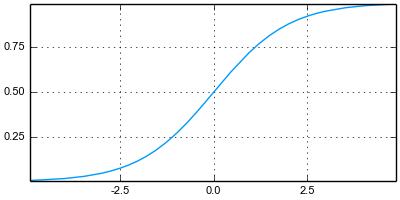

In [21]:
plot(S,-5, 5, legend=false)

La [**función logística**](https://es.wikipedia.org/wiki/Funci%C3%B3n_log%C3%ADstica) la obtenemos reemplazando $t$ por una ecuación lineal:

$$L(x) = \frac{1}{1+e^{-(\alpha+\beta_{1}X_{1})}}$$

En este contexto la usaremos para calcular la probabilidad de nuestra variable dependiente $Y$ (`:Sex`) tome una de las categorías (*Female* en este caso):

In [22]:
Py(x,α,β) = 1/(1+exp(-(α+β*x)))

Py (generic function with 1 method)

In [23]:
anim = @animate for β=filter!(x -> x != 0, collect(-10:10))
    plot(x -> Py(x,0,β), -5, 5, label=β)
end
gif(anim, "logit_beta.gif", fps = 1)

INFO: Saved animation to /home/dzea/.julia/v0.5/AnalisisDeDatosCualitativos/material/logit_beta.gif


Plots.AnimatedGif("/home/dzea/.julia/v0.5/AnalisisDeDatosCualitativos/material/logit_beta.gif")

In [24]:
anim = @animate for α=-5:1:5
    β = 2
    inflexión = -α/β
    plot(x -> Py(x,α,β), -5, 5, label=α)
    vline!([inflexión], label=inflexión)
    hline!([0.5], label="0.5")
end
gif(anim, "logit_alpha.gif", fps = 1)

INFO: Saved animation to /home/dzea/.julia/v0.5/AnalisisDeDatosCualitativos/material/logit_alpha.gif


Plots.AnimatedGif("/home/dzea/.julia/v0.5/AnalisisDeDatosCualitativos/material/logit_alpha.gif")

Los [*odds* o **chances**](https://en.wikipedia.org/wiki/Odds) de un evento se determinan dividiendo la probabilidad de que suceda el evento sobre la probabilidad de que el evento no suceda. 


$$ odds = \frac{P_{Y}}{1-P_{Y}} $$

In [25]:
odds(x,α,β) = Py(x,α,β)/(1-Py(x,α,β))

odds (generic function with 1 method)

La función [**logit**](https://en.wikipedia.org/wiki/Logit) es la inversa de la función logística, se calcula tomando el logaritmo natural de los *odds*. Nos permite transformar la función logística a la función lineal que contenía.

$$ logit = ln(odds) = \alpha+\beta_{1}X_{1} $$

In [26]:
log_odds(x,α,β) = log(odds(x,α,β)) # logit

log_odds (generic function with 1 method)

In [27]:
anim = @animate for α=-5:1:5
    β = 1
    plot(x -> Py(x,α,β), -5, 5, label="Py", ylim=(0,1)),
    plot!(x -> odds(x,α,β), -5, 5, label="odds"),
    plot!(x -> log_odds(x,α,β), -5, 5, label="logit")
end
gif(anim, "logit.gif", fps = 1)

INFO: Saved animation to /home/dzea/.julia/v0.5/AnalisisDeDatosCualitativos/material/logit.gif


Plots.AnimatedGif("/home/dzea/.julia/v0.5/AnalisisDeDatosCualitativos/material/logit.gif")

Dado que nuestra variable dependiente $Y$ sólo tiene dos valores posibles (0,1), sigue una distribución de [**Bernoulli**](https://en.wikipedia.org/wiki/Bernoulli_trial). Se usará la [**link function**](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) *logit* para hacer la transformación del valor esperado de $Y$ en nuestra [**GLM**](https://en.wikipedia.org/wiki/Logistic_regression#As_a_generalized_linear_model).

In [28]:
logística = glm(@formula(Sex ~ Height), exploración, Bernoulli(), LogitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Bernoulli{Float64},GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Sex ~ 1 + Height

Coefficients:
              Estimate Std.Error  z value Pr(>|z|)
(Intercept)    42.5616   6.34226   6.7108   <1e-10
Height       -0.247833 0.0369881 -6.70033   <1e-10


In [29]:
coef(logística)

2-element Array{Float64,1}:
 42.5616  
 -0.247833

In [30]:
α = coef(logística)[1]
β = coef(logística)[2]

-0.24783276987899816


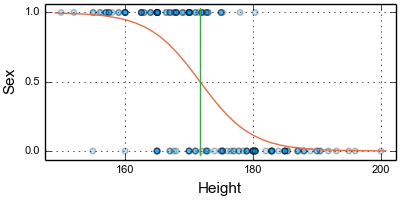

In [31]:
scatter(exploración, :Height, :Sex, alpha=0.25, legend=false)
plot!(x -> Py(x,α,β))
vline!([-α/β])

In [32]:
using RCall

LoadError: InitError: MethodError: no method matching reval_p(::String)[0m
Closest candidates are:
  reval_p([1m[31m::Ptr{RCall.ExprSxp}[0m, [1m[31m::Ptr{RCall.EnvSxp}[0m) at /home/dzea/.julia/v0.5/RCall/src/eval.jl:90
  reval_p([1m[31m::Ptr{RCall.ExprSxp}[0m) at /home/dzea/.julia/v0.5/RCall/src/eval.jl:90
  reval_p([1m[31m::Ptr{RCall.ExprSxp}[0m, [1m[31m::Ptr{RCall.EnvSxp}[0m, [1m[31m::Tuple{IO,IO,IO}[0m) at /home/dzea/.julia/v0.5/RCall/src/eval.jl:74
  ...[0m
during initialization of module RCall

In [33]:
R"""
logistica <- glm(Sex ~ Height, $exploración, family = binomial(link = "logit"))
"""

LoadError: UndefVarError: @R_str not defined

In [34]:
R"summary(logistica)"

LoadError: UndefVarError: @R_str not defined

### ¿Qué tan buena es nuestra predicción? [*Matriz de confusión*](https://en.wikipedia.org/wiki/Confusion_matrix)

In [35]:
predicción = predict(logística) # Py

clasificación = predicción .>= 0.5 # true: Female, false: Male

using FreqTables

tabla = freqtable(exploración[:Sex], clasificación)

2×2 Named Array{Int64,2}
Dim1 ╲ Dim2 │ false   true
────────────┼─────────────
0           │    70     18
1           │    15     70

|            |      Nₚ    |     Pₚ     |
|------------|------------|------------|
|   **N**        |    TN      |   FP       |
|   **P**        |    FN      |   TP       |

In [36]:
P = tabla ./ sum(tabla,2) # P(predicción|realidad)

|            |      Nₚ    |     Pₚ     |
|------------|------------|------------|
|   **N**        |      TNR, [Especificidad](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)    |   FPR      |
|   **P**        |      FNR   |   TPR, [Sensibilidad, *Recall*](https://en.wikipedia.org/wiki/Precision_and_recall)       |

In [37]:
P = tabla ./ sum(tabla,1) # P(realidad|predicción)

2×2 Array{Float64,2}:
 0.823529  0.204545
 0.176471  0.795455

|            |      Nₚ    |     Pₚ     |
|------------|------------|------------|
|   **N**        |      Negative predictive value (NPV)    |   False discovery rate (FDR)      |
|   **P**        |      False omission rate (FOR)   |   Positive predictive value (PPV), Precisión       |

### [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [38]:
# Pkg.clone("https://github.com/JuliaML/MLPlots.jl.git")
# using MLPlots

using ROCAnalysis

In [39]:
using PlotRecipes

mid_of_vec(v::AbstractVector) = v[max(1, round(Int, length(v)/2))]

@recipe function plot(roc::ROCAnalysis.Roc, auc::Bool = true)
    :legend     --> false
    :xlabel     --> "False Positive Rate"
    :ylabel     --> "True Positive Rate"
    :linestyle  --> [:solid :dash]
    :linealpha  --> [1.0 0.5]
    :label      --> ["ROC" ""]

    x = roc.pfa
    y = 1 .- roc.pmiss

    # add fill to the diagonal
    :fillrange  --> 0       # hack
    :fillalpha  --> [0.3 0] # hack

    if auc
        auc_ann = @sprintf("AUC %1.3f", 1 - ROCAnalysis.auc(roc))
        :annotation --> (mid_of_vec(x), mid_of_vec(y), text(auc_ann, :left, :top, 9, :monospace))
    end

    # xargs, yargs
    [x, [0,1]], [y, [0,1]]
end

In [40]:
objetivo    = predicción[ exploración[:Sex] .== 1 ]
no_objetivo = predicción[ exploración[:Sex] .== 0 ]

88-element Array{Float64,1}:
 0.181975  
 0.841474  
 0.0594116 
 0.308084  
 0.763789  
 0.0594116 
 0.00946634
 0.213365  
 0.00946634
 0.105976  
 0.105976  
 0.439292  
 0.29452   
 ⋮         
 0.363256  
 0.94826   
 0.841474  
 0.841474  
 0.60589   
 0.0360052 
 0.0174481 
 0.545434  
 0.0360052 
 0.0360052 
 0.105976  
 0.0577713 

In [41]:
R = ROCAnalysis.roc(objetivo, no_objetivo)

ROCAnalysis.Roc{Float64}([1.0,0.625,0.545455,0.409091,0.409091,0.340909,0.295455,0.272727,0.261364,0.25  …  0.113636,0.102273,0.0795455,0.0795455,0.0227273,0.0227273,0.0113636,0.0113636,0.0,0.0],[0.0,0.0,0.0117647,0.0117647,0.0235294,0.0235294,0.0352941,0.0705882,0.0705882,0.0941176  …  0.411765,0.435294,0.470588,0.541176,0.635294,0.788235,0.823529,0.976471,0.976471,1.0],Bool[true,true,false,true,false,true,true,false,true,false  …  false,false,false,false,true,false,false,false,true,true],[0.00090659,0.105976,0.114229,0.174712,0.181975,0.29452,0.308084,0.363256,0.422278,0.439292  …  0.716209,0.733989,0.763789,0.785411,0.841474,0.871811,0.94826,0.959154,0.984669,0.992543],[-Inf,-2.90975,-2.90975,-1.75707,-1.75707,-1.35161,0.0346856,0.0346856,0.257829,0.257829  …  1.1333,1.1333,1.1333,1.1333,1.1333,2.70883,2.70883,2.70883,2.70883,Inf])


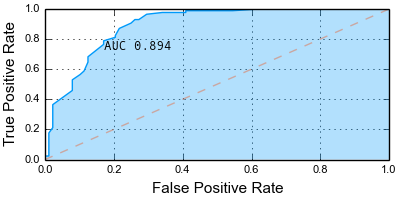

In [42]:
plot(R, xlab="1 - Especificidad", ylab="Sensibilidad")

In [43]:
AUC(R)

0.8939839572192514

#### Entrenamiento

In [45]:
coeficientes = []

entrenar(indices) = glm(@formula(Sex ~ Height), subset[indices,:], Bernoulli(), LogitLink())

function evaluar(modelo, indices)
    α = coef(modelo)[1]
    β = coef(modelo)[2]
    push!(coeficientes, [α, β]) # Guardo los coeficientes
    limite = -α/β
    real = subset[indices,:Sex] .== 0
    predicción = subset[indices,:Height] .>= limite
    100*sum(predicción & real)/sum(predicción)# PPV = TP / Pₚ
end

scores = cross_validate(
    entrenar,
    evaluar,
    nrow(subset), # N
    cv) # cross validation: 6-fold estratificado

6-element Array{Float64,1}:
 93.3333
 80.0   
 83.3333
 93.3333
 82.3529
 71.4286

In [46]:
mean_and_std(scores)

(83.96358543417367,8.383463838268014)

In [47]:
coeficientes = hcat(coeficientes...)'

6×2 Array{Float64,2}:
 42.5616  -0.247833
 45.8864  -0.267343
 44.198   -0.257597
 41.4504  -0.240969
 39.8648  -0.232443
 45.7383  -0.266934

In [48]:
α, β = (mean(coeficientes, 1)...)

(43.28326750465418,-0.25218658410505373)


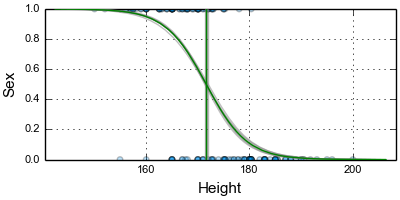

In [49]:
plt = scatter(exploración, :Height, :Sex, alpha=0.25, legend=false, ylim=(0,1))
for i in 1:size(coeficientes,1)
    alpha = coeficientes[i,1]
    beta = coeficientes[i,2]
    plot!(plt, x -> Py(x,alpha,beta), alpha=0.5, c=colorant"gray")
    vline!(plt, [-alpha/beta], alpha=0.5, c=colorant"gray")
end
plot!(plt, x -> Py(x,α,β), c=colorant"green")
vline!(plt, [-α/β], c=colorant"green")

### Múltiples variables independientes

In [51]:
completecases!(survey)
survey[:Sex] = survey[:Sex] .== "Female"
head(survey)

,Sex,WrHnd,NWHnd,WHnd,Fold,Pulse,Clap,Exer,Smoke,Height,MI,Age
1,false,18.5,18.0,Right,R on L,92,Left,Some,Never,173.0,Metric,18.25
2,false,19.5,20.5,Left,R on L,104,Left,None,Regul,177.8,Imperial,17.583
3,false,20.0,20.0,Right,Neither,35,Right,Some,Never,165.0,Metric,23.667
4,false,18.0,17.7,Right,L on R,64,Right,Some,Never,172.72,Imperial,21.0
5,false,17.7,17.7,Right,L on R,83,Right,Freq,Never,182.88,Imperial,18.833
6,false,17.0,17.3,Right,R on L,74,Right,Freq,Never,157.0,Metric,35.833


In [53]:
glm(@formula(Sex ~ Pulse + Height + Age), survey, Binomial(), LogitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial{Float64},GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Sex ~ 1 + Pulse + Height + Age

Coefficients:
                 Estimate Std.Error      z value Pr(>|z|)
(Intercept)      -21.5661   33485.1  -0.00064405   0.9995
Pulse        -3.55508e-16   149.414 -2.37935e-18   1.0000
Height       -4.27343e-15   171.836 -2.48693e-17   1.0000
Age          -5.54898e-17    281.73 -1.96961e-19   1.0000


In [54]:
using RCall 

R"""
logistica <- glm(Sex ~ Pulse + Height + Age, $survey, family = binomial(link = "logit"))
"""

RCall.RObject{RCall.VecSxp}

Call:  glm(formula = Sex ~ Pulse + Height + Age, family = binomial(link = "logit"), 
    data = `#JL`$survey)

Coefficients:
(Intercept)        Pulse       Height          Age  
 -2.657e+01    5.511e-16    2.219e-16   -4.825e-17  

Degrees of Freedom: 167 Total (i.e. Null);  164 Residual
Null Deviance:	    0 
Residual Deviance: 9.747e-10 	AIC: 8


In [55]:
R"summary(logistica)"

RCall.RObject{RCall.VecSxp}

Call:
glm(formula = Sex ~ Pulse + Height + Age, family = binomial(link = "logit"), 
    data = `#JL`$survey)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-2.409e-06  -2.409e-06  -2.409e-06  -2.409e-06  -2.409e-06  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept) -2.657e+01  5.414e+05       0        1
Pulse        5.511e-16  2.416e+03       0        1
Height       2.219e-16  2.778e+03       0        1
Age         -4.825e-17  4.555e+03       0        1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 0.0000e+00  on 167  degrees of freedom
Residual deviance: 9.7467e-10  on 164  degrees of freedom
AIC: 8

Number of Fisher Scoring iterations: 25



### [Stepwise regression](https://en.wikipedia.org/wiki/Stepwise_regression)

> In statistics, stepwise regression includes regression models in which the choice of predictive variables is carried out by an automatic procedure.

In [56]:
R"""
logistica <- step(glm(Sex ~ Pulse + Height + Age, $survey, family = binomial(link = "logit")))
"""

Start:  AIC=8
Sex ~ Pulse + Height + Age

         Df   Deviance AIC
- Pulse   1 9.7467e-10   6
- Height  1 9.7467e-10   6
- Age     1 9.7467e-10   6
<none>      9.7467e-10   8

Step:  AIC=6
Sex ~ Height + Age

         Df   Deviance AIC
- Height  1 9.7467e-10   4
- Age     1 9.7467e-10   4
<none>      9.7467e-10   6

Step:  AIC=4
Sex ~ Age

       Df   Deviance AIC
- Age   1 9.7467e-10   2
<none>    9.7467e-10   4

Step:  AIC=2
Sex ~ 1



RCall.RObject{RCall.VecSxp}

Call:  glm(formula = Sex ~ 1, family = binomial(link = "logit"), data = `#JL`$survey)

Coefficients:
(Intercept)  
     -26.57  

Degrees of Freedom: 167 Total (i.e. Null);  167 Residual
Null Deviance:	    0 
Residual Deviance: 9.747e-10 	AIC: 2


#### AIC

> El criterio de información de Akaike (AIC) es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos. Como tal, el AIC proporciona un medio para la selección del modelo.  
AIC maneja un trade-off entre la [**bondad de ajuste del modelo**](https://en.wikipedia.org/wiki/Goodness_of_fit) y la complejidad del modelo. Se basa en la entropía de información: se ofrece una estimación relativa de la información perdida cuando se utiliza un modelo determinado para representar el proceso que genera los datos.  
Dado un conjunto de modelos candidatos para los datos, el modelo preferido es el que tiene el valor mínimo en el AIC. Por lo tanto AIC no sólo recompensa la bondad de ajuste, sino también incluye una penalidad, que es una función creciente del número de parámetros estimados. Esta penalización desalienta el [**sobreajuste**](https://en.wikipedia.org/wiki/Overfitting) (aumentando el número de parámetros libres en el modelo mejora la bondad del ajuste, sin importar el número de parámetros libres en el proceso de generación de datos).
>> - [Akaike information criterion, *wiki*](https://en.wikipedia.org/wiki/Akaike_information_criterion) 